# K's Reversal Indicators のデモ

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import talib as ta
import matplotlib.dates as mdates
from datetime import date, datetime, timedelta
import numpy as np
from pandas_datareader import data as pdr
import mplfinance as mpf
plt.style.use('fivethirtyeight')

## 株価データの取得

In [2]:
# 通貨ペアはマネーパートナーズのメニューに出てくるもののみ
list_ticker = ['USDJPY=X', 'EURJPY=X', 'GBPJPY=X', 'AUDJPY=X', 'CADJPY=X', 'NZDJPY=X', 'MXNJPY=X', 'CHFJPY=X', 'NOKJPY=X',\
               'ZARJPY=X', 'TRYJPY=X', 'ILSJPY=X',\
               'EURUSD=X', 'GBPUSD=X', 'AUDUSD=X', 'NZDUSD=X', 'AUDNZD=X', 'EURGBP=X', 'GBPAUD=X']

In [3]:
# Define the stock symbol and timeframe
# 現保有銘柄
#symbol = 'AUDUSD=X'
symbol = '9984.T'
end_date = datetime.today()
start_date = end_date - timedelta(days=1095)
# 新しくインストールしたyfinanceの場合
data = yf.download(symbol, start_date, end_date)
# 古いyfinanceの場合
#yf.pdr_override()
#df = pdr.get_data_yahoo(ticker, start, end)
data.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-01,8800.0,8805.0,8505.0,8555.0,8555.0,15878200
2024-08-02,7997.0,8098.0,7776.0,7868.0,7868.0,17731700
2024-08-05,7245.0,7400.0,6368.0,6400.0,6400.0,23784300
2024-08-06,7000.0,7267.0,6805.0,7172.0,7172.0,21353000
2024-08-07,6912.0,7232.0,6890.0,7231.0,7231.0,2568300


## K's Reversal Indicator (I) 戦略の実装

In [4]:
def kr_1_strategy(df):
    kr_Buy = []
    kr_Sell = []
    df['bbub'],df['bbmb'],df['bblb'] = ta.BBANDS(df['Adj Close'], timeperiod=100, nbdevup=1.5, nbdevdn=1.5)
    df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    for i in range(0, len(df)):
        if df['Adj Close'][i] <= df['bblb'][i] and df['macd'][i-1] <= df['macdsignal'][i-1] \
           and df['macd'][i] > df['macdsignal'][i]:
            kr_Sell.append(np.nan)
            kr_Buy.append(df['Adj Close'][i])
        elif df['Adj Close'][i] >= df['bbub'][i] and df['macd'][i-1] >= df['macdsignal'][i-1] \
           and df['macd'][i] < df['macdsignal'][i]:
            kr_Buy.append(np.nan)
            kr_Sell.append(df['Adj Close'][i])        
        else:
            kr_Buy.append(np.nan)
            kr_Sell.append(np.nan)

    df['kr_Buy_Signal_price'] = kr_Buy
    df['kr_Sell_Signal_price'] = kr_Sell
    return df

In [5]:
df1 = data.copy()
df1 = kr_1_strategy(df1)
df1

C:\Users\nicjp\AppData\Local\Temp\ipykernel_15808\4144543020.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Adj Close'][i] <= df['bblb'][i] and df['macd'][i-1] <= df['macdsignal'][i-1] \
C:\Users\nicjp\AppData\Local\Temp\ipykernel_15808\4144543020.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['Adj Close'][i] >= df['bbub'][i] and df['macd'][i-1] >= df['macdsignal'][i-1] \
C:\Users\nicjp\AppData\Local\Temp\ipykernel_15808\4144543020.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent w

,Open,High,Low,Close,Adj Close,Volume,bbub,bbmb,bblb,macd,macdsignal,macdhist,kr_Buy_Signal_price,kr_Sell_Signal_price
Date,,,,,,,,,,,,,,
2021-08-10,6819.0,6909.0,6771.0,6831.0,6683.462402,8389900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-11,6915.0,6961.0,6646.0,6711.0,6566.055176,11394400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-12,6759.0,6780.0,6652.0,6654.0,6510.286133,7754300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-13,6666.0,6680.0,6583.0,6647.0,6503.437500,8453400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-16,6580.0,6591.0,6462.0,6505.0,6364.504395,8919500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,8800.0,8805.0,8505.0,8555.0,8555.000000,15878200,10830.632190,9197.460059,7564.287927,-340.475805,-48.345211,-292.130593,NaN,NaN
2024-08-02,7997.0,8098.0,7776.0,7868.0,7868.000000,17731700,10829.750442,9184.573223,7539.396003,-462.449908,-131.166151,-331.283757,NaN,NaN
2024-08-05,7245.0,7400.0,6368.0,6400.0,6400.000000,23784300,10857.346622,9162.532910,7467.719199,-669.848992,-238.902719,-430.946273,NaN,NaN


## K's Reversal Indicator (I) 戦略の図示

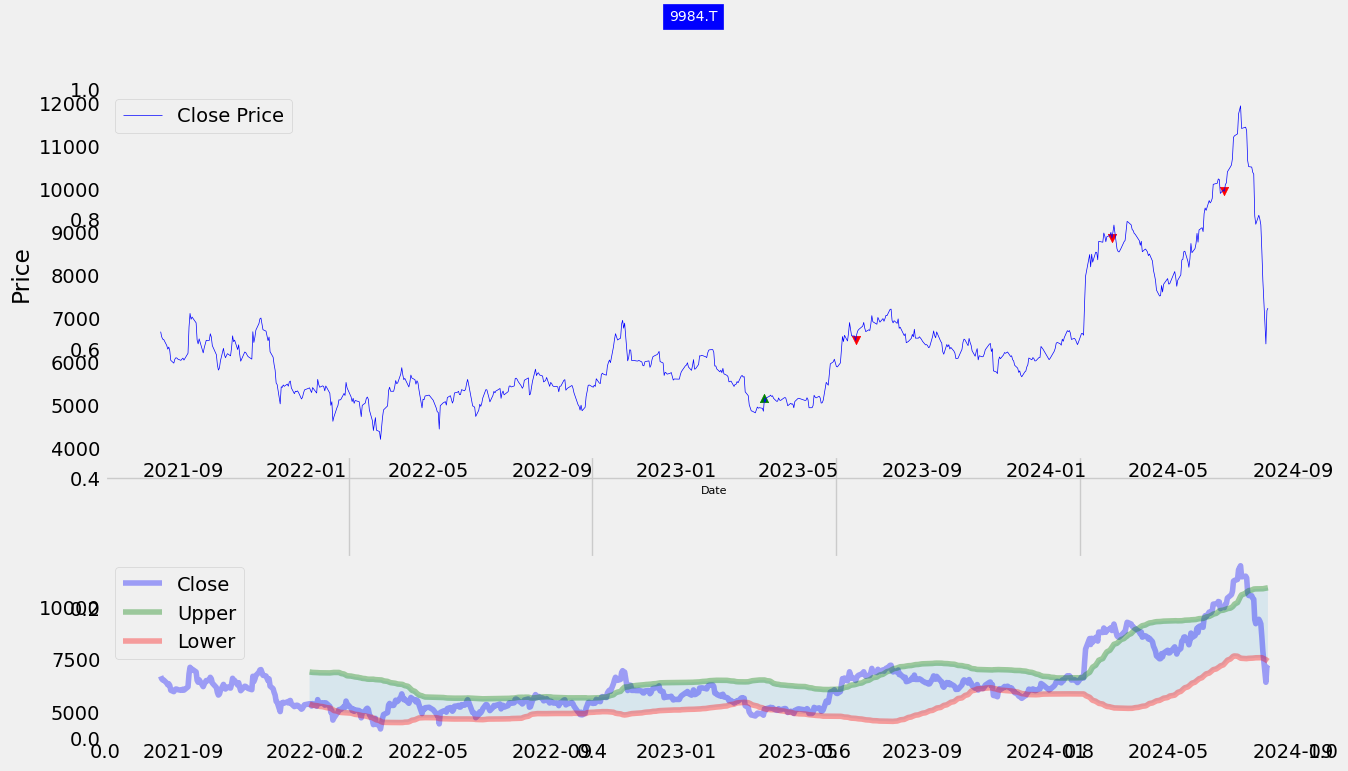

In [6]:
#plot
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(symbol, fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price')
ax1.plot(df1['Adj Close'],label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(df1.index, df1['kr_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(df1.index, df1['kr_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.plot(df1['Adj Close'], label='Close', color='blue', alpha=0.35) #middle band
ax2.plot(df1['bbub'], label='Upper', color='green', alpha=0.35) #Upper band
ax2.plot(df1['bblb'], label='Lower', color='red', alpha=0.35) #lower band
ax2.fill_between(df1.index, df1['bbub'], df1['bblb'], alpha=0.1)
ax2.legend(loc='upper left')
ax2.grid()
plt.show()

In [7]:
df1[['kr_Buy_Signal_price','kr_Sell_Signal_price']].tail(1)

,kr_Buy_Signal_price,kr_Sell_Signal_price
Date,,
2024-08-07,NaN,NaN


## K's Reversal Indicator (III) 戦略の実装

In [8]:
def kr_3_strategy(df):
    kr_Buy = []
    kr_Sell = []
    df['return1'] = df['Adj Close'].diff(1)
    df['return14'] = df['Adj Close'].diff(14)
    df['rtcorr'] = df['return1'].corr(df['return14'])
    df['RSI'] = ta.RSI(df['Adj Close'], timeperiod=14)

    for i in range(0, len(df)):
        if df['rtcorr'][i] > 0.6 and df['RSI'][i] < 40:
            kr_Sell.append(np.nan)
            kr_Buy.append(df['Adj Close'][i])
        elif df['rtcorr'][i] > 0.6 and df['RSI'][i] > 60:
            kr_Buy.append(np.nan)
            kr_Sell.append(df['Adj Close'][i])        
        else:
            kr_Buy.append(np.nan)
            kr_Sell.append(np.nan)

    df['kr_Buy_Signal_price'] = kr_Buy
    df['kr_Sell_Signal_price'] = kr_Sell
    return df

In [9]:
df3 = data.copy()
df3 = kr_3_strategy(df3)
df3

C:\Users\nicjp\AppData\Local\Temp\ipykernel_15808\901565275.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['rtcorr'][i] > 0.6 and df['RSI'][i] < 40:
C:\Users\nicjp\AppData\Local\Temp\ipykernel_15808\901565275.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['rtcorr'][i] > 0.6 and df['RSI'][i] > 60:


,Open,High,Low,Close,Adj Close,Volume,return1,return14,rtcorr,RSI,kr_Buy_Signal_price,kr_Sell_Signal_price
Date,,,,,,,,,,,,
2021-08-10,6819.0,6909.0,6771.0,6831.0,6683.462402,8389900,NaN,NaN,0.315349,NaN,NaN,NaN
2021-08-11,6915.0,6961.0,6646.0,6711.0,6566.055176,11394400,-117.407227,NaN,0.315349,NaN,NaN,NaN
2021-08-12,6759.0,6780.0,6652.0,6654.0,6510.286133,7754300,-55.769043,NaN,0.315349,NaN,NaN,NaN
2021-08-13,6666.0,6680.0,6583.0,6647.0,6503.437500,8453400,-6.848633,NaN,0.315349,NaN,NaN,NaN
2021-08-16,6580.0,6591.0,6462.0,6505.0,6364.504395,8919500,-138.933105,NaN,0.315349,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,8800.0,8805.0,8505.0,8555.0,8555.000000,15878200,-607.000000,-3365.0,0.315349,25.503400,NaN,NaN
2024-08-02,7997.0,8098.0,7776.0,7868.0,7868.000000,17731700,-687.000000,-3527.0,0.315349,20.831704,NaN,NaN
2024-08-05,7245.0,7400.0,6368.0,6400.0,6400.000000,23784300,-1468.000000,-5025.0,0.315349,14.654405,NaN,NaN


In [10]:
df3.describe()

,Open,High,Low,Close,Adj Close,Volume,return1,return14,rtcorr,RSI,kr_Buy_Signal_price,kr_Sell_Signal_price
count,736.000000,736.000000,736.000000,736.000000,736.000000,7.360000e+02,735.000000,722.000000,7.360000e+02,722.000000,0.0,0.0
mean,6398.805707,6486.264946,6318.044837,6399.123641,6343.732720,1.351082e+07,0.744949,52.125876,3.153491e-01,51.133987,NaN,NaN
std,1385.482548,1403.026139,1367.892590,1383.289101,1403.666697,7.648802e+06,174.822595,712.580438,2.055309e-15,12.824593,NaN,NaN
min,4318.000000,4388.000000,4210.000000,4265.000000,4186.464355,1.515100e+06,-1468.000000,-5025.000000,3.153491e-01,14.654405,NaN,NaN
25%,5459.500000,5530.000000,5395.000000,5481.750000,5394.797119,8.190700e+06,-78.927979,-288.551758,3.153491e-01,43.048548,NaN,NaN
50%,6084.500000,6137.000000,6012.500000,6076.000000,6022.433594,1.157950e+07,1.988281,38.898438,3.153491e-01,49.773074,NaN,NaN
75%,6700.000000,6786.500000,6621.250000,6685.000000,6636.341919,1.647242e+07,85.397705,365.499512,3.153491e-01,59.828526,NaN,NaN
max,12050.000000,12180.000000,11810.000000,11920.000000,11920.000000,6.885210e+07,772.000000,2395.162598,3.153491e-01,87.450265,NaN,NaN


## K's Reversal Indicator III 戦略の図示

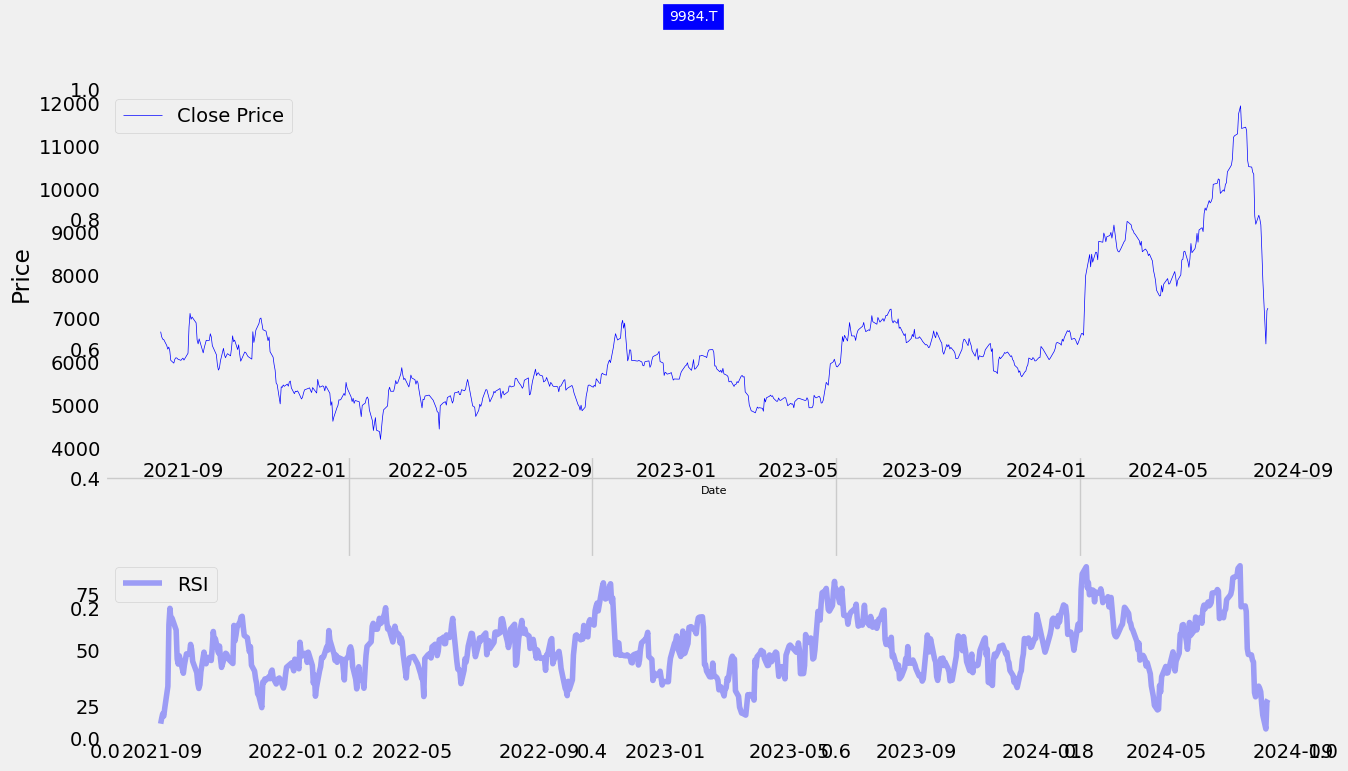

In [11]:
#plot
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(symbol, fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price')
ax1.plot(df3['Adj Close'],label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(df3.index, df3['kr_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(df3.index, df3['kr_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.plot(df3['RSI'], label='RSI', color='blue', alpha=0.35)
ax2.legend(loc='upper left')
ax2.grid()
plt.show()